<a href="https://colab.research.google.com/github/traikdude/renovation-tracker/blob/master/Renovation_Tracker_OCR_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏗️ Renovation Tracker - Handwritten OCR Pipeline

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/traikdude/renovation-tracker/blob/master/Renovation_Tracker_OCR_Pipeline.ipynb)

This notebook provides a complete OCR pipeline for processing handwritten renovation notes, task lists, and financial documents. It extracts data and uploads it to Google Sheets for easy tracking.

## 📋 What This Notebook Includes:

1. **Quick Demo** - Test OCR on sample images
2. **Full Pipeline** - Complete processing with all parsers
3. **Interactive Mode** - Upload your own images and process them
4. **Google Sheets Integration** - Authenticate and upload data
5. **Visualizations** - See confidence scores and results

---

## 🔧 Section 1: Setup & Installation

First, we'll install all required dependencies including Tesseract OCR.

In [1]:
%%capture
# Install system dependencies
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev

# Install Python packages
!pip install pytesseract opencv-python-headless pillow gspread google-auth google-api-python-client pandas openpyxl

In [2]:
# Verify Tesseract installation
import pytesseract
import cv2
from PIL import Image
import numpy as np

print("✅ Tesseract version:", pytesseract.get_tesseract_version())
print("✅ All dependencies installed successfully!")

✅ Tesseract version: 4.1.1
✅ All dependencies installed successfully!


## 📦 Section 2: Clone Repository & Import Modules

Clone the renovation-tracker repository from GitHub to access all the parsers and utilities.

In [3]:
# Clone the repository
!git clone https://github.com/traikdude/renovation-tracker.git
%cd renovation-tracker

print("✅ Repository cloned successfully!")
print("\n📁 Project files:")
!ls -1 *.py

Cloning into 'renovation-tracker'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 1), reused 38 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 1.47 MiB | 27.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/renovation-tracker
✅ Repository cloned successfully!

📁 Project files:
check_sheet_status.py
clear_worksheets.py
create_test_images.py
google_sheets_integration.py
handwritten_ocr_pipeline.py
layout_parser.py
moving_guide_parser.py
parse_moving_guide.py
setup_google_sheets.py
task_parser.py
transaction_parser.py
upload_moving_tasks.py


In [4]:
# Import required modules
import sys
import os
from pathlib import Path

# Add current directory to path
sys.path.insert(0, os.getcwd())

# Import parsers
from transaction_parser import TransactionParser
from task_parser import TaskParser
from layout_parser import LayoutParser
from moving_guide_parser import MovingGuideParser

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


## 🚀 Section 3: Quick Demo - Test OCR

Let's test the OCR on sample images included in the repository.

📸 Found 13 sample images

Testing with: financial_notes.jpg


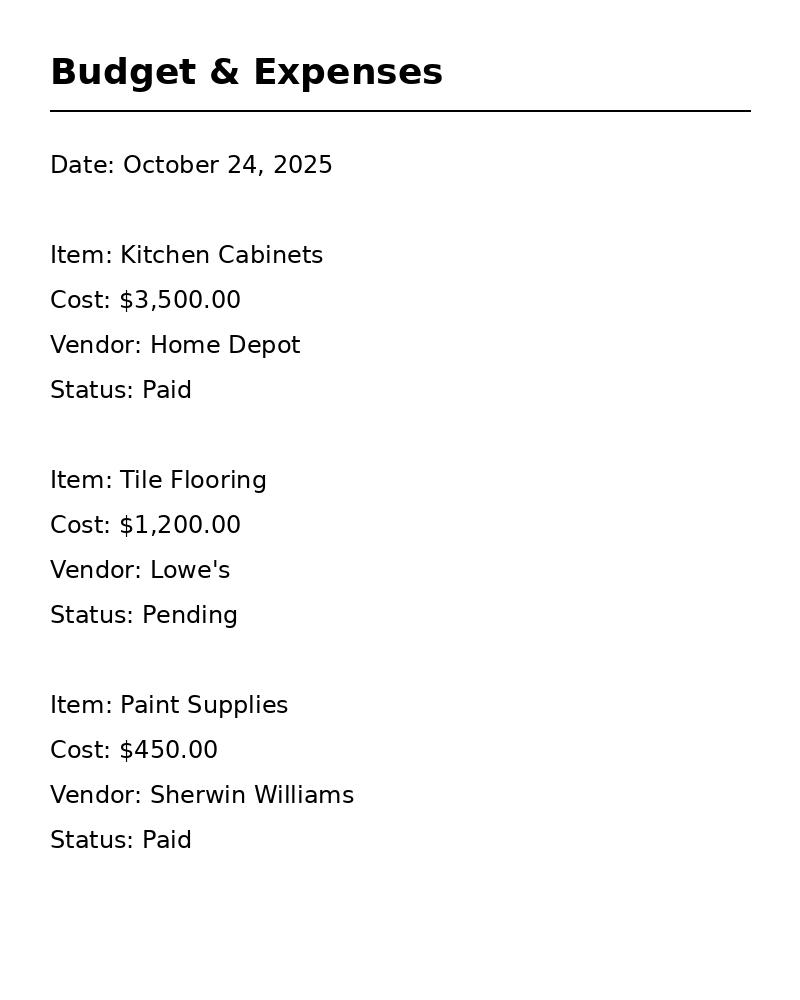


📝 EXTRACTED TEXT:
Budget & Expenses

 

Date: October 24, 2025

Item: Kitchen Cabinets
Cost: $3,500.00
Vendor: Home Depot
Status: Paid

Item: Tile Flooring
Cost: $1,200.00
Vendor: Lowe's

Status: Pending

Item: Paint Supplies
Cost: $450.00
Vendor: Sherwin Williams

Status: Paid



In [5]:
from IPython.display import display, Image as IPImage
import glob

# List available sample images
sample_images = glob.glob("images/*.jpg") + glob.glob("images/*.jpeg")
print(f"📸 Found {len(sample_images)} sample images\n")

# Display first sample image
if sample_images:
    test_image = sample_images[0]
    print(f"Testing with: {os.path.basename(test_image)}")
    display(IPImage(filename=test_image, width=400))

    # Run OCR
    img = cv2.imread(test_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)

    print("\n" + "="*50)
    print("📝 EXTRACTED TEXT:")
    print("="*50)
    print(text[:500] + "..." if len(text) > 500 else text)
else:
    print("⚠️ No sample images found. You can upload your own in the next section!")

## 📤 Section 4: Interactive Mode - Upload Your Own Images

Upload your handwritten notes, receipts, or task lists and process them.

In [7]:
from google.colab import files
from IPython.display import display, Image as IPImage
import io

print("📤 Upload one or more images to process")
print("Supported formats: .jpg, .jpeg, .png\n")

uploaded = files.upload()

# Create uploads directory
!mkdir -p uploads

uploaded_files = []
for filename in uploaded.keys():
    filepath = f"uploads/{filename}"
    with open(filepath, 'wb') as f:
        f.write(uploaded[filename])
    uploaded_files.append(filepath)
    print(f"✅ Saved: {filename}")

print(f"\n📸 Total uploaded: {len(uploaded_files)} image(s)")

📤 Upload one or more images to process
Supported formats: .jpg, .jpeg, .png




📸 Total uploaded: 0 image(s)


In [8]:
# Display uploaded images
for filepath in uploaded_files:
    print(f"\n{'='*60}")
    print(f"📄 {os.path.basename(filepath)}")
    print(f"{'='*60}")
    display(IPImage(filename=filepath, width=500))

## 🔍 Section 5: Process Images with OCR

Extract text from uploaded images with confidence scoring.

In [9]:
import pandas as pd

def process_image_with_confidence(image_path):
    """Process image and return text with confidence scores"""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply preprocessing
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Get text and confidence data
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
    text = pytesseract.image_to_string(gray)

    # Calculate average confidence
    confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
    avg_confidence = sum(confidences) / len(confidences) if confidences else 0

    return text, avg_confidence, data

# Process all uploaded images
results = []

for filepath in uploaded_files:
    filename = os.path.basename(filepath)
    print(f"\n🔄 Processing: {filename}...")

    text, confidence, data = process_image_with_confidence(filepath)

    results.append({
        'filename': filename,
        'text': text,
        'confidence': confidence,
        'word_count': len(text.split())
    })

    print(f"   ✅ Confidence: {confidence:.1f}%")
    print(f"   ✅ Words extracted: {len(text.split())}")
    print(f"\n   Preview: {text[:200]}...")

# Create results dataframe
df_results = pd.DataFrame(results)
print("\n" + "="*60)
print("📊 PROCESSING SUMMARY")
print("="*60)
display(df_results[['filename', 'confidence', 'word_count']])


📊 PROCESSING SUMMARY


KeyError: "None of [Index(['filename', 'confidence', 'word_count'], dtype='object')] are in the [columns]"

## 🧩 Section 6: Intelligent Parsers

Use specialized parsers to extract structured data from different document types.

### 💰 Transaction Parser - Financial Documents

In [ ]:
# Initialize transaction parser
transaction_parser = TransactionParser()

print("💰 TRANSACTION PARSER")
print("="*60)
print("Use this for: receipts, expense notes, budget sheets\n")

# Process financial documents
for result in results:
    text = result['text']

    # Check if this looks like a financial document
    if any(keyword in text.lower() for keyword in ['$', 'price', 'total', 'cost', 'paid', 'expense']):
        print(f"\n📄 Processing: {result['filename']}")
        transactions = transaction_parser.parse(text)

        if transactions:
            df_trans = pd.DataFrame(transactions)
            print(f"   ✅ Found {len(transactions)} transaction(s)")
            display(df_trans)
        else:
            print("   ⚠️ No transactions detected")

### ✅ Task Parser - Checklists & To-Do Lists

In [ ]:
# Initialize task parser
task_parser = TaskParser()

print("✅ TASK PARSER")
print("="*60)
print("Use this for: checklists, to-do lists, task lists\n")

# Process task documents
for result in results:
    text = result['text']

    # Check if this looks like a task list
    if any(keyword in text.lower() for keyword in ['task', 'todo', 'checklist', '[ ]', '[x]', 'complete']):
        print(f"\n📄 Processing: {result['filename']}")
        tasks = task_parser.parse(text)

        if tasks:
            df_tasks = pd.DataFrame(tasks)
            print(f"   ✅ Found {len(tasks)} task(s)")
            display(df_tasks)
        else:
            print("   ⚠️ No tasks detected")

### 📐 Layout Parser - Property Information

In [ ]:
# Initialize layout parser
layout_parser = LayoutParser()

print("📐 LAYOUT PARSER")
print("="*60)
print("Use this for: property layouts, room dimensions, floor plans\n")

# Process layout documents
for result in results:
    text = result['text']

    # Check if this looks like a layout document
    if any(keyword in text.lower() for keyword in ['room', 'ft', 'feet', 'dimension', 'area', 'bedroom', 'kitchen']):
        print(f"\n📄 Processing: {result['filename']}")
        layouts = layout_parser.parse(text)

        if layouts:
            df_layouts = pd.DataFrame(layouts)
            print(f"   ✅ Found {len(layouts)} room/area(s)")
            display(df_layouts)
        else:
            print("   ⚠️ No layout information detected")

### 📦 Moving Guide Parser - Moving Checklists

In [ ]:
# Initialize moving guide parser
moving_parser = MovingGuideParser()

print("📦 MOVING GUIDE PARSER")
print("="*60)
print("Use this for: moving checklists, packing guides, relocation tasks\n")

# Process moving documents
for result in results:
    text = result['text']

    # Check if this looks like a moving guide
    if any(keyword in text.lower() for keyword in ['moving', 'packing', 'pack', 'box', 'relocation']):
        print(f"\n📄 Processing: {result['filename']}")
        moving_tasks = moving_parser.parse(text)

        if moving_tasks:
            df_moving = pd.DataFrame(moving_tasks)
            print(f"   ✅ Found {len(moving_tasks)} moving task(s)")
            display(df_moving)
        else:
            print("   ⚠️ No moving tasks detected")

## 📊 Section 7: Visualizations

Visualize OCR confidence scores and processing statistics.

In [ ]:
import matplotlib.pyplot as plt

if results:
    # Confidence scores bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Confidence Scores
    filenames = [r['filename'] for r in results]
    confidences = [r['confidence'] for r in results]

    axes[0].bar(range(len(filenames)), confidences, color='steelblue')
    axes[0].set_xticks(range(len(filenames)))
    axes[0].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in filenames], rotation=45, ha='right')
    axes[0].set_ylabel('Confidence (%)')
    axes[0].set_title('OCR Confidence Scores by Image')
    axes[0].axhline(y=70, color='r', linestyle='--', label='Good threshold (70%)')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Plot 2: Word Count
    word_counts = [r['word_count'] for r in results]

    axes[1].bar(range(len(filenames)), word_counts, color='coral')
    axes[1].set_xticks(range(len(filenames)))
    axes[1].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in filenames], rotation=45, ha='right')
    axes[1].set_ylabel('Word Count')
    axes[1].set_title('Words Extracted per Image')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n📈 SUMMARY STATISTICS")
    print("="*60)
    print(f"Average Confidence: {sum(confidences)/len(confidences):.1f}%")
    print(f"Total Words Extracted: {sum(word_counts)}")
    print(f"Images Processed: {len(results)}")
else:
    print("⚠️ No results to visualize. Upload and process images first!")

## 📊 Section 8: Google Sheets Integration

Upload extracted data to Google Sheets for tracking and management.

In [10]:
from google.colab import auth
from google.auth import default
import gspread

print("🔐 Google Sheets Authentication\n")
print("This will allow the notebook to access your Google Sheets.")
print("Click the link below and authorize access.\n")

# Authenticate with Google
auth.authenticate_user()
creds, _ = default()

# Initialize gspread client
gc = gspread.authorize(creds)

print("✅ Authentication successful!")
print("\nYou can now upload data to Google Sheets.")

🔐 Google Sheets Authentication

This will allow the notebook to access your Google Sheets.
Click the link below and authorize access.

✅ Authentication successful!

You can now upload data to Google Sheets.


In [ ]:
# Upload data to Google Sheets
from datetime import datetime

def upload_to_google_sheets(spreadsheet_id, worksheet_name, data_df):
    """Upload DataFrame to Google Sheets"""
    try:
        # Open spreadsheet
        spreadsheet = gc.open_by_key(spreadsheet_id)

        # Get or create worksheet
        try:
            worksheet = spreadsheet.worksheet(worksheet_name)
        except:
            worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=100, cols=20)

        # Add timestamp column
        data_df['Uploaded At'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # Convert to list format for gspread
        values = [data_df.columns.tolist()] + data_df.values.tolist()

        # Clear existing data and upload new data
        worksheet.clear()
        worksheet.update('A1', values)

        print(f"✅ Uploaded {len(data_df)} rows to '{worksheet_name}'")
        return True
    except Exception as e:
        print(f"❌ Error uploading to Google Sheets: {e}")
        return False

# Example usage
print("📤 UPLOAD TO GOOGLE SHEETS")
print("="*60)
print("\nTo upload data, you need:")
print("1. Your Google Spreadsheet ID (from the URL)")
print("2. The worksheet name to upload to\n")

# Uncomment and fill in your details to upload:
# SPREADSHEET_ID = "your_spreadsheet_id_here"
# WORKSHEET_NAME = "OCR Results"
# upload_to_google_sheets(SPREADSHEET_ID, WORKSHEET_NAME, df_results)

print("💡 Tip: Uncomment the code above and add your spreadsheet ID to upload results!")

## 💾 Section 9: Google Drive Integration (Optional)

Mount Google Drive to access images stored in your Drive.

In [11]:
from google.colab import drive

print("📁 Mounting Google Drive...\n")
drive.mount('/content/drive')

print("\n✅ Google Drive mounted at /content/drive/")
print("\nYou can now access files from your Google Drive!")
print("\nExample: Process images from Drive folder:")
print("   drive_folder = '/content/drive/MyDrive/RenovationImages'")
print("   images = glob.glob(f'{drive_folder}/*.jpg')")

📁 Mounting Google Drive...

Mounted at /content/drive

✅ Google Drive mounted at /content/drive/

You can now access files from your Google Drive!

Example: Process images from Drive folder:
   drive_folder = '/content/drive/MyDrive/RenovationImages'
   images = glob.glob(f'{drive_folder}/*.jpg')


## 💾 Section 10: Export Results

Save extracted data locally as Excel or CSV files.

In [ ]:
import openpyxl

# Export results to Excel
if results:
    output_file = 'renovation_tracker_results.xlsx'

    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Save OCR results summary
        df_results.to_excel(writer, sheet_name='OCR Summary', index=False)

        # Save extracted text for each image
        for idx, result in enumerate(results):
            sheet_name = f"Text_{idx+1}"
            df_text = pd.DataFrame({'Text': [result['text']]})
            df_text.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"✅ Results exported to: {output_file}")
    print(f"   - OCR Summary sheet")
    print(f"   - {len(results)} text extraction sheets\n")

    # Download the file
    files.download(output_file)
    print("📥 Download started!")
else:
    print("⚠️ No results to export. Process images first!")

## 🔄 Section 11: Full Automated Pipeline

Run the complete pipeline: upload → OCR → parse → export → upload to Sheets

In [ ]:
def run_full_pipeline(image_paths, spreadsheet_id=None):
    """
    Complete OCR pipeline:
    1. Process images with OCR
    2. Run all parsers
    3. Generate summary report
    4. Export to Excel
    5. Upload to Google Sheets (optional)
    """
    print("🚀 FULL PIPELINE STARTED")
    print("="*70)

    all_results = {
        'ocr_summary': [],
        'transactions': [],
        'tasks': [],
        'layouts': [],
        'moving_tasks': []
    }

    # Step 1: OCR Processing
    print("\n📸 Step 1: Processing images with OCR...")
    for image_path in image_paths:
        filename = os.path.basename(image_path)
        print(f"   - {filename}")

        text, confidence, _ = process_image_with_confidence(image_path)

        all_results['ocr_summary'].append({
            'filename': filename,
            'confidence': confidence,
            'word_count': len(text.split()),
            'text_preview': text[:100]
        })

        # Step 2: Run parsers
        print(f"   🔍 Running intelligent parsers...")

        # Transaction parser
        transactions = transaction_parser.parse(text)
        if transactions:
            for t in transactions:
                t['source_file'] = filename
            all_results['transactions'].extend(transactions)
            print(f"      💰 {len(transactions)} transaction(s)")

        # Task parser
        tasks = task_parser.parse(text)
        if tasks:
            for t in tasks:
                t['source_file'] = filename
            all_results['tasks'].extend(tasks)
            print(f"      ✅ {len(tasks)} task(s)")

        # Layout parser
        layouts = layout_parser.parse(text)
        if layouts:
            for l in layouts:
                l['source_file'] = filename
            all_results['layouts'].extend(layouts)
            print(f"      📐 {len(layouts)} layout(s)")

        # Moving parser
        moving = moving_parser.parse(text)
        if moving:
            for m in moving:
                m['source_file'] = filename
            all_results['moving_tasks'].extend(moving)
            print(f"      📦 {len(moving)} moving task(s)")

    # Step 3: Generate summary
    print("\n📊 Step 2: Generating summary report...")
    print(f"   - Images processed: {len(image_paths)}")
    print(f"   - Transactions found: {len(all_results['transactions'])}")
    print(f"   - Tasks found: {len(all_results['tasks'])}")
    print(f"   - Layouts found: {len(all_results['layouts'])}")
    print(f"   - Moving tasks found: {len(all_results['moving_tasks'])}")

    # Step 4: Export to Excel
    print("\n💾 Step 3: Exporting to Excel...")
    output_file = f'renovation_tracker_full_pipeline_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx'

    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        pd.DataFrame(all_results['ocr_summary']).to_excel(writer, sheet_name='OCR Summary', index=False)

        if all_results['transactions']:
            pd.DataFrame(all_results['transactions']).to_excel(writer, sheet_name='Transactions', index=False)

        if all_results['tasks']:
            pd.DataFrame(all_results['tasks']).to_excel(writer, sheet_name='Tasks', index=False)

        if all_results['layouts']:
            pd.DataFrame(all_results['layouts']).to_excel(writer, sheet_name='Layouts', index=False)

        if all_results['moving_tasks']:
            pd.DataFrame(all_results['moving_tasks']).to_excel(writer, sheet_name='Moving Tasks', index=False)

    print(f"   ✅ Saved: {output_file}")

    # Step 5: Upload to Google Sheets (if spreadsheet_id provided)
    if spreadsheet_id:
        print("\n📤 Step 4: Uploading to Google Sheets...")

        if all_results['transactions']:
            upload_to_google_sheets(spreadsheet_id, 'Transactions', pd.DataFrame(all_results['transactions']))

        if all_results['tasks']:
            upload_to_google_sheets(spreadsheet_id, 'Tasks', pd.DataFrame(all_results['tasks']))

        if all_results['layouts']:
            upload_to_google_sheets(spreadsheet_id, 'Layouts', pd.DataFrame(all_results['layouts']))

        if all_results['moving_tasks']:
            upload_to_google_sheets(spreadsheet_id, 'Moving Tasks', pd.DataFrame(all_results['moving_tasks']))

    print("\n✅ PIPELINE COMPLETE!")
    print("="*70)

    # Download results
    files.download(output_file)

    return all_results

# Run the full pipeline on uploaded images
if uploaded_files:
    # Uncomment to run with Google Sheets upload:
    # SPREADSHEET_ID = "your_spreadsheet_id_here"
    # pipeline_results = run_full_pipeline(uploaded_files, spreadsheet_id=SPREADSHEET_ID)

    # Run without Google Sheets upload:
    pipeline_results = run_full_pipeline(uploaded_files)
else:
    print("⚠️ No images uploaded. Please upload images in Section 4 first!")

## 💡 Tips & Best Practices

### For Best OCR Results:
- ✅ Use high-resolution images (300 DPI or higher)
- ✅ Ensure good lighting and contrast
- ✅ Keep text horizontal (rotate images if needed)
- ✅ Avoid blurry or skewed images

### Parser Selection:
- **Transaction Parser**: Receipts, invoices, expense notes
- **Task Parser**: Checklists, to-do lists, project tasks
- **Layout Parser**: Room dimensions, property layouts
- **Moving Parser**: Moving guides, packing checklists

### Google Sheets Setup:
1. Create a new Google Sheet or use existing one
2. Copy the spreadsheet ID from the URL
3. Run the authentication cell in Section 8
4. Use the upload functions to push data

---

## 🐛 Troubleshooting

**Low Confidence Scores (<70%)**
- Improve image quality
- Try preprocessing (rotate, enhance contrast)
- Check if handwriting is legible

**No Data Parsed**
- Verify the text contains relevant keywords
- Check parser is appropriate for document type
- Review extracted text for accuracy

**Google Sheets Upload Fails**
- Verify authentication completed successfully
- Check spreadsheet ID is correct
- Ensure you have edit access to the sheet

---

## 📚 Resources

- **GitHub Repository**: https://github.com/traikdude/renovation-tracker
- **Tesseract Documentation**: https://github.com/tesseract-ocr/tesseract
- **gspread Documentation**: https://docs.gspread.org/

---

**Built with Python • Tesseract OCR • Google Colab**
